<a href="https://www.kaggle.com/code/mosesmoncy/fruit-classification-using-cnn?scriptVersionId=136531636" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Fruit classification using CNN is a machine learning technique that involves training a convolutional neural network (CNN) on a dataset of images of different types of fruits. The CNN learns to identify patterns in the images and classify them into different fruit categories based on these patterns. This technique can be used in various industries, such as agriculture, to automate the process of fruit sorting and grading, which can improve efficiency and reduce labor costs.

Importing General Libraries

In [1]:
# General Libs
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Exploratory Analysis

Let's view some dataset samples.

This example uses keras ImageDataGenerator. This lib turns easier to read and use image classes from a subdirectoty structure.

In [2]:
im_shape = (250,250)

TRAINING_DIR = '/kaggle/input/amazon-fruits-small/ds_frutas_am/train'
TEST_DIR = '/kaggle/input/amazon-fruits-small/ds_frutas_am/test'

seed = 10

BATCH_SIZE = 16

In [3]:
#Using keras ImageGenerator and flow_from_directoty

# Subdivision in test/validation
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [4]:
# If you want data augmentation, uncomment and run this cell
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
# Generating for train part
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generating for validation part
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generating for test dataset
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)


nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


Creating a simple CNN Model

In [6]:
model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 20)      560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 20)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 40)      7240      
                                                                 
 flatten (Flatten)           (None, 595360)            0         
                                                                 
 dense (Dense)               (None, 100)               59536100  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                        

In [7]:
epochs = 80

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/80
4/4 [==============================] - ETA: 0s - loss: 36.7552 - accuracy: 0.2321
Epoch 1: val_loss improved from inf to 25.83508, saving model to model.h5
4/4 [==============================] - 9s 2s/step - loss: 36.7552 - accuracy: 0.2321 - val_loss: 25.8351 - val_accuracy: 0.1250
Epoch 2/80
4/4 [==============================] - ETA: 0s - loss: 22.5604 - accuracy: 0.1607
Epoch 2: val_loss improved from 25.83508 to 4.94075, saving model to model.h5
4/4 [==============================] - 7s 2s/step - loss: 22.5604 - accuracy: 0.1607 - val_loss: 4.9408 - val_accuracy: 0.2500
Epoch 3/80
4/4 [==============================] - ETA: 0s - loss: 6.1906 - accuracy: 0.1786
Epoch 3: val_loss improved from 4.94075 to 2.23763, saving model to model.h5
4/4 [==============================] - 7s 2s/step - loss: 6.1906 - accuracy: 0.1786 - val_loss: 2.2376 - val_accuracy: 0.2500
Epoch 4/80
4/4 [==============================] - ETA: 0s - loss: 1.8991 - accuracy: 0.3571
Epoch 4: val_loss im

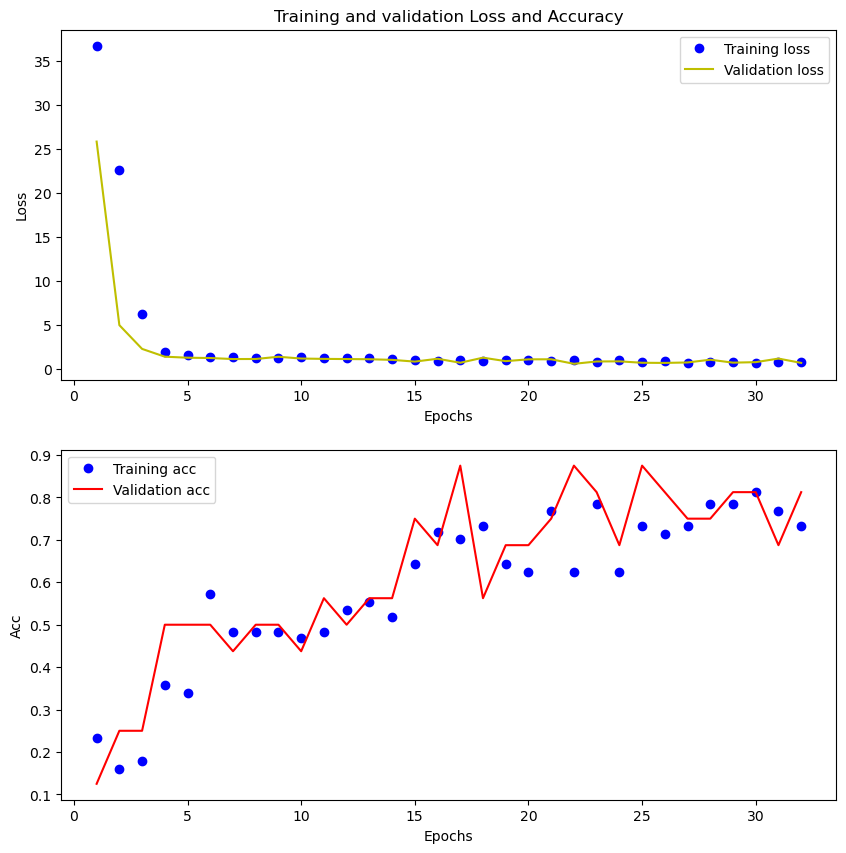

In [8]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'y', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'r', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

Evaluating the model

In [9]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [10]:
# Using the validation dataset
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

/tmp/ipykernel_20/1237713776.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator)


Val loss: 0.5268236398696899
Val accuracy: 0.8888888955116272


In [11]:
# Using the test dataset
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/tmp/ipykernel_20/4054959399.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator)


Test loss: 0.9356657266616821
Test accuracy: 0.6333333253860474


In [12]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#On test dataset
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/tmp/ipykernel_20/2937054504.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Classification Report
              precision    recall  f1-score   support

        acai       0.71      1.00      0.83         5
     cupuacu       1.00      0.40      0.57         5
    graviola       0.50      1.00      0.67         5
     guarana       0.57      0.80      0.67         5
     pupunha       1.00      0.20      0.33         5
      tucuma       0.67      0.40      0.50         5

    accuracy                           0.63        30
   macro avg       0.74      0.63      0.60        30
weighted avg       0.74      0.63      0.60        30



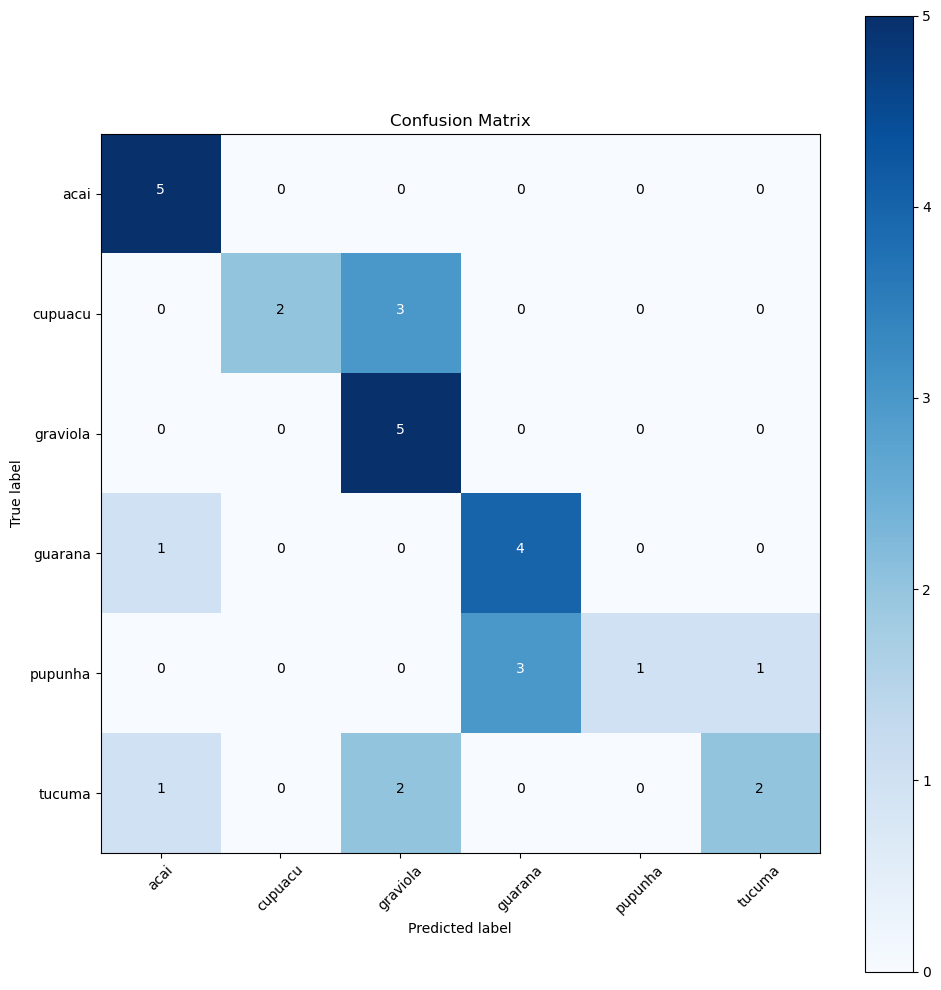

In [14]:
#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
